In [1]:
# load necessary packages and view available data
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
# load data
train = pd.read_csv('CMAPSSData/train_FD001.txt', sep = ' ', header = None)
train

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN


In [3]:
# drop NULL columns
train.drop(train.columns[[26, 27]], axis=1, inplace=True)

In [4]:
# the files did not contain headers. Here I create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns

# name columns
train.columns = column_names

In [5]:
train[train['UnitNumber'] == 1].head(5)


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [6]:
# this section calculates Remaining Useful Life (RUL) for the training data
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

max_cycle

,UnitNumber,MaxOfCycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [7]:
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')
train_merged.head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,MaxOfCycle
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


In [8]:
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
Target_Remaining_Useful_Life

0        191
1        190
2        189
3        188
4        187
        ... 
20626      4
20627      3
20628      2
20629      1
20630      0
Length: 20631, dtype: int64

In [9]:
# from Series(Target_Remaining_Useful_Life) to pandas(train_merge) to first pandas dataframe(train with target)
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life

# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [10]:
#drop columns we dont need
leakage_to_drop = ['UnitNumber', 'Cycle']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
train_no_leakage

,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [11]:
train_no_leakage

,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [12]:
# set up features(X) and target(y) variable for feature importance
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

In [13]:
# feature selection
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)

single_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
# printing out the important features found by RandomForest
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)


Sensor_11       0.488393
Sensor_9        0.131452
Sensor_4        0.091061
Sensor_12       0.042105
Sensor_7        0.031789
Sensor_14       0.031660
Sensor_15       0.027879
Sensor_21       0.025643
Sensor_3        0.022256
Sensor_2        0.021502
Sensor_20       0.018345
Sensor_13       0.017265
Op_Setting_1    0.016723
Sensor_8        0.016657
Op_Setting_2    0.009469
Sensor_17       0.007292
Sensor_6        0.000509
Sensor_16       0.000000
Sensor_10       0.000000
Sensor_18       0.000000
Sensor_5        0.000000
Sensor_19       0.000000
Sensor_1        0.000000
Op_Setting_3    0.000000
dtype: float64


In [15]:
# turning this into a classification dataframe, in ortder to confidently identify when an asset is within its last 15 cycles?
# generate label columns for training data
cycles = 15
train_no_leakage['Target_15_Cycles'] = np.where(train_no_leakage['Target_Remaining_Useful_Life'] <= cycles, 1, 0 )

In [16]:
# based on random forest feature importance, I excluded sensors without much valuable information
vars_to_drop = ["Sensor_"+str(i) for i in [16, 10, 18, 5, 19, 1]]
vars_to_drop.append("Op_Setting_3")
vars_to_drop.append("Target_Remaining_Useful_Life")
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)

train_final

,Op_Setting_1,Op_Setting_2,Sensor_2,Sensor_3,Sensor_4,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,Target_15_Cycles
0,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0
1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0
2,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0
3,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0
4,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,1
20627,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,1
20628,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,1
20629,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [17]:
y = train_final['Target_15_Cycles']
X = train_final.drop(['Target_15_Cycles'], axis = 1)

In [18]:
# random forest
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [19]:
# print tables we created so far

# print("original table:", train_final.count(axis=1).shape[0])
# print("\n")
# print("Dataset X: ", X.count(axis=1).shape[0])
# print("Labels y: ", y.count())
# print("\n")
# print("X_train= ", X_train.count(axis=1).shape[0])
# print("y_train= ", y_train.count())
# print("\n")
# print("X_test= ", X_test.count(axis=1).shape[0])
# print("y_test= ", y_test.count())

In [20]:
# print("y_train - Number of 0 labels: ", y_train[y_train == 0].count())
# print("y_train - Number of 1 labels:", y_train[y_train == 1].count())

# print("\n")

# print("y_test - Number of 0 labels :", y_test[y_test == 0].count())
# print("y_test - Number of 1 labels: ", y_test[y_test == 1].count())

In [21]:
# create variable to hold the X_train columns for the multiple model solution.
columns_final = [*range(0,17)]

columns_final = X_train.columns



In [22]:
# create four sets of the original, X_train set, and assign column names to it.
X_train_part_1 = pd.DataFrame(columns = columns_final)
X_train_part_2 = pd.DataFrame(columns = columns_final)
X_train_part_3 = pd.DataFrame(columns = columns_final)
X_train_part_4 = pd.DataFrame(columns = columns_final)

In [23]:
# assign original X_train values to the new train sets
X_train_part_1 = X_train.iloc[0:4126]
X_train_part_2 = X_train.iloc[4126:8252]
X_train_part_3 = X_train.iloc[8252:12378]
X_train_part_4 = X_train.iloc[12378:16504]

In [24]:
# assign original y_train labels
y_train_part_1 = y_train.iloc[0:4126]
y_train_part_2 = y_train.iloc[4126:8252]
y_train_part_3 = y_train.iloc[8252:12378]
y_train_part_4 = y_train.iloc[12378:16504]

In [25]:
# choose the model
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier

# classifier for single model solution
rf = ensemble.RandomForestClassifier()

# classifiers for multiple model solution
rf_1 = ensemble.RandomForestClassifier()
rf_2 = ensemble.RandomForestClassifier()
rf_3 = ensemble.RandomForestClassifier()
rf_4 = ensemble.RandomForestClassifier()

In [26]:
# set up 5-fold cross-validation
from sklearn import model_selection, preprocessing
cv = model_selection.KFold(5)

In [27]:
from sklearn.pipeline import Pipeline

# setting the single model solution
# create pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 25, 50]
my_max_depth = [8, 9, 10, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = None
                            , verbose = 10
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)

# create variable to predict X_test
y_pred = optimized_rf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:    2.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.6s finished
/home/nero/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
# show the best model estimators
print(optimized_rf.best_estimator_)


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)


In [29]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Accuracy: correctly predicted to the total
# Accuracy = TP+TN/TP+FP+FN+TN
Average_accuracy = [(accuracy_score(y_test, y_pred))]

print("Accuracy of single model: " + "{:.2%}".format(accuracy_score(y_test, y_pred)))

Accuracy of single model: 97.67%


In [30]:
# Precision: correctly predicted positive  to the total predicted positive
# Precision = TP/TP+FP
Average_precision = [(precision_score(y_test, y_pred))]

print("Precision of single model: " + "{:.2%}".format((precision_score(y_test, y_pred))))

Precision of single model: 81.19%


In [31]:
# Recall: correctly predicted positive to total in actual class
# Recall = TP/TP+FN
Average_Recall = [(recall_score(y_test, y_pred))]

print("Recall of single model: " + "{:.2%}".format(recall_score(y_test, y_pred)))

Recall of single model: 86.32%


In [32]:
print("Train set score: ",optimized_rf.score(X_train, y_train))
print("Test set score: ", optimized_rf.score(X_test, y_test))

Train set score:  0.9926684440135725
Test set score:  0.976738551005573


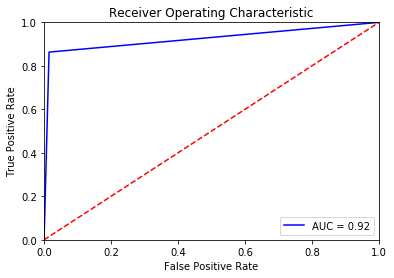

In [43]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
#end of single model solution

In [35]:
# create 4 pipelines for each model  
pipeline_part_1 = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf_1) ])

pipeline_part_2 = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf_2) ])

pipeline_part_3 = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf_3) ])

pipeline_part_4 = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf_4) ])

In [36]:
# using GrindSearch for each of 4 models
optimized_rf_1 = GridSearchCV(estimator=pipeline_part_1
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )

optimized_rf_2 = GridSearchCV(estimator=pipeline_part_2
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )

optimized_rf_3 = GridSearchCV(estimator=pipeline_part_3
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )

optimized_rf_4 = GridSearchCV(estimator=pipeline_part_4
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'roc_auc'
                            , verbose = 1
                            , n_jobs = -1
                           )

In [37]:
# train the four models of the multiple model solution
optimized_rf_1.fit(X_train_part_1, y_train_part_1)
optimized_rf_2.fit(X_train_part_2, y_train_part_2)
optimized_rf_3.fit(X_train_part_3, y_train_part_3)
optimized_rf_4.fit(X_train_part_4, y_train_part_4)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
/home/nero/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
/home/nero/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
/home/nero/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished
/home/nero/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardize',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                      

In [38]:
# show the best model estimators
y_pred_1 = optimized_rf_1.predict(X_test)
y_pred_2 = optimized_rf_2.predict(X_test)
y_pred_3 = optimized_rf_3.predict(X_test)
y_pred_4 = optimized_rf_4.predict(X_test)

In [39]:
# print(optimized_rf_1.best_estimator_)
# print(optimized_rf_2.best_estimator_)
# print(optimized_rf_3.best_estimator_)
# print(optimized_rf_4.best_estimator_)

In [40]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Accuracy: correctly predicted to the total
# Accuracy = TP+TN/TP+FP+FN+TN
Average_accuracy = [(accuracy_score(y_test, y_pred_4)), (accuracy_score(y_test, y_pred_3)), 
                    (accuracy_score(y_test, y_pred_2)),(accuracy_score(y_test, y_pred_1))]

print("Average Accuracy of multiple models: " + "{:.2%}".format(sum(Average_accuracy) / len(Average_accuracy)))
print(" Accuracy of single model: " + "{:.2%}".format(accuracy_score(y_test, y_pred)))



Average Accuracy of multiple models: 97.37%
 Accuracy of single model: 97.67%


In [41]:
# Precision: correctly predicted positive  to the total predicted positive
# Precision = TP/TP+FP
Average_precision = [(precision_score(y_test, y_pred_4)), (precision_score(y_test, y_pred_3)), 
                    (precision_score(y_test, y_pred_2)),(precision_score(y_test, y_pred_1))]

print("Average Precision of multiple models: " + "{:.2%}".format(sum(Average_precision) / len(Average_precision)))
print("Precision of single model: " + "{:.2%}".format((precision_score(y_test, y_pred))))


Average Precision of multiple models: 80.29%
Precision of single model: 81.19%


In [42]:
# Recall: correctly predicted positive to total in actual class
# Recall = TP/TP+FN
Average_Recall = [(recall_score(y_test, y_pred_4)), (recall_score(y_test, y_pred_3)), 
                    (recall_score(y_test, y_pred_2)),(recall_score(y_test, y_pred_1))]

print("Average Recall of multiple models: " + "{:.2%}".format(sum(Average_precision) / len(Average_precision)))
print("Recall of single model: " + "{:.2%}".format(recall_score(y_test, y_pred)))

Average Recall of multiple models: 80.29%
Recall of single model: 86.32%
